In [65]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


def OLS(X, Y):
    X_T = np.transpose(X)
    Betas = np.dot(np.dot(np.matrix(np.dot(X_T, X)).I, X_T), Y)
    Betas = np.array(Betas)
    return Betas


def Predict(X, Betas):
    Y_predict = np.dot(X, Betas)
    return Y_predict


def add_ones(X):
    ones = np.ones((X.shape[0], 1))
    X = np.hstack((ones, X))
    return X

    
def T_test(Betas, X, Y, Y_pre, N, K, col_names):
    Betas_interval = []
    beta_num = Betas.shape[0]
    U = Y - Y_pre
    S_sq = np.dot(U.transpose(), U)[0][0] / (N-K-1)
    SKK = np.matrix(np.dot(X.transpose(), X)).I
    for j in range(beta_num):
        Skk = SKK[j, j]
        Beta_i = Betas[j, 0]
        t_value = Beta_i/(Skk*S_sq)**0.5
        std = (Skk*S_sq)**0.5
        low = Beta_i-1.97*std
        up = Beta_i+1.97*std
        if Beta_i>low and Beta_i<up:
            IN_interval = 1
        else:
            IN_interval = 0
        PR = 2*(1- stats.t.cdf(abs(t_value), N-beta_num))
        ls_tmp = [Beta_i, t_value, PR, low, up, IN_interval]
        Betas_interval.append(ls_tmp)
        
    # transform into dataframe
    numpy_data = np.array(Betas_interval)
    df2 = pd.DataFrame(data=numpy_data, index=col_names, 
        columns=["beta", "t-value", "Pr(>|t|)", "low_bound", 'up_boud', 'in'])
    return numpy_data, df2
    

def R_suqare(Y_predict, Y):
    Y_mean = np.mean(Y)
    RSS = np.sum((Y_predict-Y)**2)
    TSS = np.sum((Y-Y_mean)**2)
    return 1- RSS/TSS


def Ftest(Betas, Y_predict, Y, K, N):
    ESS = np.sum((Y_predict-Y)**2)
    RSS = np.sum((Y_predict-np.mean(Y))**2)
    F = RSS/K/(ESS/(N-K-1))
    P_v = 2*(1- stats.f.cdf(F, K, N-K-1))
    return F, P_v


def ridge_reg(X, Y, lam=0.1):
    X_T = np.transpose(X)
    weights_num = X.shape[1]
    Betas = np.dot(np.dot(np.matrix(np.dot(X_T, X)+lam*np.identity(weights_num)).I, X_T), Y)
    Betas = np.array(Betas)
    return Betas

# 1 read data

In [173]:
data = pd.read_csv('./data_problemset1/Car_Prices.csv')
table = data.to_numpy()
data

,CC,HP,Year,Kilometers,Gas_1/ Diesel_0,ABS,ABD,CD,AW,A_C,MP,Car_Price
0,1600,105,1995,160000,1,1,1,1,1,1,1.0,8414.17
1,1896,136,1995,130000,1,1,1,1,0,0,1.0,12000.00
2,1800,140,1993,112000,1,1,1,1,1,0,0.0,8000.00
3,1900,140,1998,60000,1,1,1,1,1,1,1.0,12621.25
4,2000,150,1992,114000,1,1,0,0,0,0,1.0,7900.00
...,...,...,...,...,...,...,...,...,...,...,...,...
69,1800,140,1992,135000,1,1,1,1,1,0,0.0,9320.00
70,2000,136,1999,62000,0,1,1,0,1,0,1.0,19750.00
71,1895,105,2000,65000,1,1,1,1,1,1,1.0,16000.00
72,2500,193,1992,230000,1,1,0,1,1,1,1.0,9990.00


# 2 a

### simple regression

In [174]:
Xa = table[:, 3]
N = Xa.shape[0]
Xa = np.reshape(Xa, (Xa.shape[0], 1))
Xa = add_ones(Xa)
Ya = table[:, 11]
Ya = np.reshape(Ya, (Ya.shape[0], 1))
beta_a = OLS(Xa, Ya)
Y_prea = Predict(Xa, beta_a)
K = 1
col_names = ['Intercept', 'Kilometers']
numpy_data, Ttesta = T_test(beta_a, Xa, Ya, Y_prea, N, K, col_names)
R2a = R_suqare(Y_prea, Ya)
print(round(R2a, 5))
F, F_v = Ftest(beta_a, Y_prea, Ya, K, N)
print(F, F_v)
Ttesta
R2a = R_suqare(Y_prea, Ya)
print(R2a)

0.39967
47.934236225474436 3.0587348209820675e-09
0.39967100082547646


In [175]:
Ttesta

,beta,t-value,Pr(>|t|),low_bound,up_boud,in
Intercept,25001.265755,15.528837,0.000000e+00,21829.586185,28172.945325,1.0
Kilometers,-0.099622,-6.923456,1.529367e-09,-0.127968,-0.071275,1.0


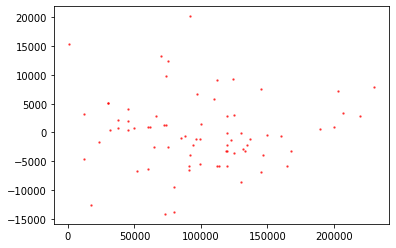

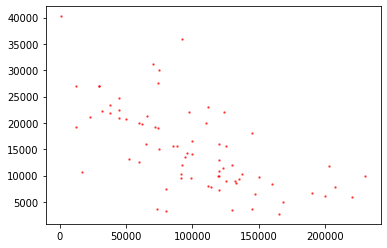

In [70]:
plt.scatter(table[:, 3], Ya - Y_prea, alpha=0.6, color='r', s=2)  
plt.show()
plt.scatter(table[:, 3], Ya, alpha=0.6, color='r', s=2)
plt.show()

### nonlinearity test

In [139]:
Kio = table[:, 3]**2
Kio2 = np.reshape(Kio, (Kio.shape[0], 1))
Xa1 = np.hstack((Xa, Kio2))
beta_a1 = OLS(Xa1, Ya)
Y_prea1 = Predict(Xa1, beta_a1)
col_names = ['Intercept',  'Kilometers^1', 'Kilometers^2']
K = 2
numpy_data, Ttesta = T_test(beta_a1, Xa1, Ya, Y_prea1, N, K, col_names)
R2a = R_suqare(Y_prea1, Ya)
print(round(R2a, 5))
#F, F_v = Ftest(beta_a, Y_prea, Ya, K, N)
#print(F, F_v)
Ttesta

0.42884


,beta,t-value,Pr(>|t|),low_bound,up_boud,in
Intercept,2.871171e+04,11.441685,0.000000,2.376820e+04,3.365522e+04,1.0
Kilometers^1,-1.871940e-01,-3.891119,0.000223,-2.819667e-01,-9.242119e-02,1.0
Kilometers^2,4.004251e-07,1.904364,0.060915,-1.380109e-08,8.146513e-07,1.0


In [130]:
beta_a1

array([[ 2.87117131e+04],
       [-1.87193954e-01],
       [ 4.00425125e-07]])

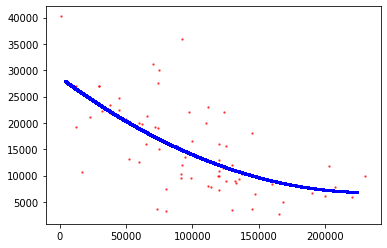

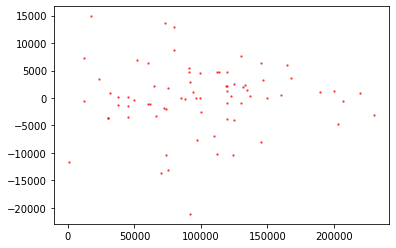

In [114]:
test_x = [i+4000 for i in range(220000)]
ys = []
for x_i in test_x:
    y_i = beta_a1[0]+ beta_a1[1]*x_i + beta_a1[2]*x_i**2
    ys.append(y_i)
plt.scatter(table[:, 3], Ya, alpha=0.6, color='r', s=2)
plt.scatter(test_x, ys, alpha=0.6, color='b', s=2)
plt.show()
plt.scatter(table[:, 3], Y_prea1 - Ya, alpha=0.6, color='r', s=2)
plt.show()

# 3d

## correlation matrix

In [177]:
data = pd.read_csv('./data_problemset1/Car_Prices.csv')
data.rename(columns={'Gas_1/ Diesel_0':'Gas_1_Diesel_0'},inplace=True)
corrdf = data.corr()
corrdf['Car_Price']

CC                0.241198
HP                0.372381
Year              0.767791
Kilometers       -0.632195
Gas_1_Diesel_0   -0.292497
ABS               0.394046
ABD               0.556508
CD                0.174620
AW                0.056937
A_C               0.133255
MP                0.357452
Car_Price         1.000000
Name: Car_Price, dtype: float64

In [178]:
data['Kilometers2'] = data['Kilometers']**2
data

,CC,HP,Year,Kilometers,Gas_1_Diesel_0,ABS,ABD,CD,AW,A_C,MP,Car_Price,Kilometers2
0,1600,105,1995,160000,1,1,1,1,1,1,1.0,8414.17,25600000000
1,1896,136,1995,130000,1,1,1,1,0,0,1.0,12000.00,16900000000
2,1800,140,1993,112000,1,1,1,1,1,0,0.0,8000.00,12544000000
3,1900,140,1998,60000,1,1,1,1,1,1,1.0,12621.25,3600000000
4,2000,150,1992,114000,1,1,0,0,0,0,1.0,7900.00,12996000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1800,140,1992,135000,1,1,1,1,1,0,0.0,9320.00,18225000000
70,2000,136,1999,62000,0,1,1,0,1,0,1.0,19750.00,3844000000
71,1895,105,2000,65000,1,1,1,1,1,1,1.0,16000.00,4225000000
72,2500,193,1992,230000,1,1,0,1,1,1,1.0,9990.00,52900000000


In [145]:
from statsmodels.formula.api import ols
formula = 'Car_Price ~ CC+HP+Year+Kilometers+Kilometers2+Gas_1_Diesel_0+ABS+ABD+CD+A_C+MP'
results0 = ols(formula, data).fit()
print(results0.summary())

                            OLS Regression Results                            
Dep. Variable:              Car_Price   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     44.16
Date:                Sun, 01 Nov 2020   Prob (F-statistic):           1.48e-23
Time:                        14:54:00   Log-Likelihood:                -631.88
No. Observations:                  68   AIC:                             1288.
Df Residuals:                      56   BIC:                             1314.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.788e+06   3.15e+05     -5.

In [179]:
from statsmodels.formula.api import ols
formula = 'Car_Price ~ HP+Year+Kilometers+Gas_1_Diesel_0'
results = ols(formula, data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Car_Price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     105.2
Date:                Tue, 03 Nov 2020   Prob (F-statistic):           1.32e-28
Time:                        16:51:41   Log-Likelihood:                -697.80
No. Observations:                  74   AIC:                             1406.
Df Residuals:                      69   BIC:                             1417.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -2.38e+06   2.53e+05     -9.

In [142]:
beta_a1[2][0]

4.0042512471437037e-07

In [143]:
hypotheses = '(Intercept = {}), (HP = {}), (Year = {}), (Kilometers = {}), \
              (Kilometers2 = {}), (Gas_1_Diesel_0 = {})'.format(
              beta_a1[0][0],0,0,beta_a1[1][0],beta_a1[2][0],0)
f_test = results.f_test(hypotheses)
print(f_test)

<F test: F=array([[49.35962862]]), p=2.6053548808919783e-21, df_denom=68, df_num=5>


/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  'rank is %d' % (J, J_), ValueWarning)


# e

In [144]:
hypotheses1 = ' (Year = {})'.format(1200)
f_test1 = results.f_test(hypotheses1)
print(f_test1)

<F test: F=array([[0.10270328]]), p=0.7495921392917642, df_denom=68, df_num=1>


In [146]:
hypotheses2 = '(CC = {}),(ABS = {})'.format(0,0)
f_test2 = results0.f_test(hypotheses2)
print(f_test2)

<F test: F=array([[0.59590929]]), p=0.5545176555998494, df_denom=56, df_num=2>


In [147]:
hypotheses3 = 'CD = Gas_1_Diesel_0'
f_test3 = results0.f_test(hypotheses3)
print(f_test3)

<F test: F=array([[8.24144435]]), p=0.005769024526534222, df_denom=56, df_num=1>


In [180]:
hypotheses4 = '-4*Year = 20000*Kilometers'
f_test3 = results.f_test(hypotheses4)
print(f_test3)

<F test: F=array([[39.50618746]]), p=2.554695777125571e-08, df_denom=69, df_num=1>


In [186]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
white_test5 = het_white(results.resid**2,  results.model.exog)
white_test5

(47.32635327874932,
 4.092434445336051e-06,
 9.019225293079671,
 1.2508760461592233e-09)

In [184]:
bp_test61 = het_breuschpagan(results.resid**2, np.reshape(results.model.exog[:, 2], (74, 1)))
bp_test61

(3.0350620870010916, nan, 3.1220985865260014, 0.08141703514224242)

In [185]:
bp_test62 = het_breuschpagan(results.resid**2, np.reshape(results.model.exog[:, 1], (74, 1)))
bp_test62

(4.4522398088808846, nan, 4.673241886656862, 0.03391483195355937)

# f

In [171]:
from statsmodels.formula.api import ols
formula = 'Car_Price ~ HP+Year+Kilometers+Kilometers2+Gas_1_Diesel_0'
results_f = ols(formula, data).fit(cov_type='HC3')
print(results_f.summary())

                            OLS Regression Results                            
Dep. Variable:              Car_Price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     40.81
Date:                Sun, 01 Nov 2020   Prob (F-statistic):           2.12e-17
Time:                        15:36:13   Log-Likelihood:                -692.90
No. Observations:                  74   AIC:                             1398.
Df Residuals:                      68   BIC:                             1412.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2.305e+06   3.39e+05     -6.

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)
